In [3]:
#! pip install py2neo
#!pip install neo4j
#!pip install neomodel
from neo4j import GraphDatabase
import pandas as pd
from sodapy import Socrata
from py2neo import Graph
from neo4j import graph
from py2neo import Relationship
import neomodel
from neomodel import StructuredNode, StringProperty, RelationshipTo, RelationshipFrom, config
import os
import importlib
import dask.dataframe as dd
from dask.distributed import Client

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

In [ ]:
serverURL = 'localhost:7474'
dbURL = 'http://localhost:7687/db/data'
account = "neo4j"
password = "****"

In [365]:
client=Client()

In [366]:
client

Client Scheduler: tcp://127.0.0.1:64356 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 51.34 GB


In [ ]:
# client = Socrata("data.cms.gov", None)
#results = client.get("j75i-rw8y", limit=2000)
#tax_df = pd.DataFrame.from_records(results)
#tax_df.to_pickle('taxonomy.pkl')

In [49]:
npi_df=pd.read_csv('npidata_pfile_20050523-20200209.csv', usecols = ['NPI', 'Entity Type Code','Provider Last Name (Legal Name)', 'Provider First Name','Provider Name Prefix Text','Provider Name Suffix Text','Provider Credential Text',
                            'Provider Organization Name (Legal Business Name)','Provider Other Organization Name',
                              'Provider First Line Business Practice Location Address', 'Provider Business Practice Location Address City Name', 'Provider Business Practice Location Address State Name','Provider Business Mailing Address Postal Code','Healthcare Provider Taxonomy Code_1'])
#npi_df.to_pickle('npi.pkl')

C:\Users\Lydia\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [74]:
#tax=pd.read_pickle('taxonomy.pkl')
#hop = pd.read_pickle('hop.pkl')
#npi = pd.read_pickle('npi.pkl')
#npi_tax_merged=pd.read_pickle('npi_tax_merged.pkl')
#clean_npi_tax=pd.read('clean_npi_tax.pkl')
#hop_df = pd.read_pickle('hop.pkl')
#hop_ready4neo=pd.read_csv('hop_ready4neo.csv')
#tax=pd.read_pickle('taxonomy.pkl')

In [195]:
test_tn=npi_df[npi_df['Provider Business Practice Location Address State Name']=='TN']

In [196]:
test_tn.shape

(109510, 14)

In [199]:
test2=test_tn[test_tn['Provider Organization Name (Legal Business Name)'].str.contains('HOSPITAL')==True]

In [201]:
test2.shape

(687, 14)

In [202]:
test3=test2[test2.NPI.isin(hop_df.to_npi)]

In [203]:
test3.shape

(206, 14)

In [53]:
#tax['Healthcare Provider Taxonomy Code_1']=tax['provider_taxonomy_code']
tax=tax[['Healthcare Provider Taxonomy Code_1','provider_taxonomy_desc']]
npi_tax_merged=pd.merge(npi_df,tax)

In [25]:
#npi_tax_merged.to_pickle('npi_tax_merged.pkl')
#npi_tax_merged=pd.read_pickle('npi_tax_merged.pkl')

In [71]:
clean_npi_tax=npi_tax_merged[['NPI', 'Entity Type Code', 'Provider Organization Name (Legal Business Name)', 'provider_taxonomy_desc',
                              'Provider Business Practice Location Address State Name',"Provider Business Mailing Address Postal Code"]]

In [72]:
clean_npi_tax=npi_tax_merged[['NPI', 'Entity Type Code', 'Provider Organization Name (Legal Business Name)',
                              'Provider Business Practice Location Address State Name','Provider Business Mailing Address Postal Code','provider_taxonomy_desc']]
clean_npi_tax['speciality']=clean_npi_tax['provider_taxonomy_desc'].str.split('/').str[1]
#clean_npi_tax['speciality']=clean_npi_tax['speciality'].str.split(',').str[0]
clean_npi_tax['Facility']=clean_npi_tax['Provider Organization Name (Legal Business Name)']
clean_npi_tax['state']=clean_npi_tax['Provider Business Practice Location Address State Name']
clean_npi_tax['zipcode']=clean_npi_tax['Provider Business Mailing Address Postal Code']
clean_npi_tax=clean_npi_tax[['NPI', 'Entity Type Code','speciality', 'Facility','state','zipcode']]

C:\Users\Lydia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Lydia\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Lydia\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [77]:
def internal_medcine_cleaner(raw):
    speciality=[]
    key='Internal Medicine'
    coma=','
    for i in raw.speciality.astype(str):
        if key in i and coma in i :
            speciality.append(i.split(',')[1])
        elif coma in i:
            speciality.append(i.split(',')[0])
        else:
            speciality.append(i)
    return(speciality)       

In [78]:
clean_npi_tax['speciality']=internal_medcine_cleaner(clean_npi_tax)

In [76]:
clean_npi_tax.zipcode=clean_npi_tax.zipcode.astype(str)

In [82]:
#clean_npi_tax.to_pickle('clean_npi_tax.pkl')

In [43]:
hop=hop_df
#Filter transaction_count > 50, average_day_wait < 50
hop=hop[(hop['transaction_count'] > 50) & (hop['average_day_wait'] < 50)].reset_index(drop=True)

In [83]:
provider=clean_npi_tax[clean_npi_tax['Entity Type Code']==1].reset_index(drop=True)
facility=clean_npi_tax[clean_npi_tax['Entity Type Code']==2].reset_index(drop=True)
hospital=facility[facility.Facility.str.contains('HOSPITAL')==True].reset_index(drop=True)

#Filter from_npi, Entity Type = 1 

entity1filter=hop['from_npi'].isin(provider['NPI'])==False
hop=hop.drop(hop[entity1filter].index)

#Filter to_npi, Entity Type = 2 
entity2filter=hop['to_npi'].isin(facility['NPI'])==False
hop=hop.drop(hop[entity2filter].index)

# filter to_npi, Hospital
hospitalfilter=hop['to_npi'].isin(hospital['NPI'])==False
hop=hop.drop(hop[hospitalfilter].index)
hop=hop.reset_index(drop=True)

In [57]:
#npi_taxcode=pd.read_csv('npidata_pfile_20050523-20200209.csv',usecols = ['NPI', 'Entity Type Code','Healthcare Provider Taxonomy Code_1'])
#npi_taxcode.to_pickle('npi_taxonomy.pkl')

In [361]:
#only save the tax codes that are found in the npi dataset
#taxfilter=tax.provider_taxonomy_code.isin(npi_taxcode['Healthcare Provider Taxonomy Code_1'])==False
#tax=tax.drop(tax[taxfilter].index)
#tax=tax[['provider_taxonomy_code','provider_taxonomy_desc']]

In [89]:
#drop rows from npi dataframe whose npi value is not in 'from_npi' column of the hopping dataset.
#to get the speciality names of from_npi values from the npi dataset
from_npi_filter=clean_npi_tax['NPI'].isin(hop.from_npi)==False
from_specialists_df=clean_npi_tax.drop(clean_npi_tax[from_npi_filter].index)
from_specialists_df['from_npi']=from_specialists_df['NPI']
from_specialists_df['from_speciality']=from_specialists_df['speciality']
from_specialists_df=from_specialists_df[['from_npi', 'from_speciality','state','zipcode']].reset_index(drop=True)

In [88]:
#drop rows from npi dataframe whose npi value is not in 'to_npi' column of the hopping dataset.
#to get the speciality names of to_npi values from the npi dataset
to_npi_filter=clean_npi_tax['NPI'].isin(hop.to_npi)==False
to_hospitals_df=clean_npi_tax.drop(clean_npi_tax[to_npi_filter].index)
to_hospitals_df['to_npi']=to_hospitals_df['NPI']
to_hospitals_df['to_Facility']=to_hospitals_df['Facility']
to_hospitals_df=to_hospitals_df[['to_npi', 'to_Facility','state','zipcode']].reset_index(drop=True)

In [90]:
hop4neo=pd.merge(hop,from_specialists_df)
hop4neo=pd.merge(hop4neo,to_hospitals_df)

In [96]:
#Within a local CBSA, show which hospitals specialists typically refer patients to
#hop4neo.head(1)

In [93]:
hop_ready4neo=hop4neo[['from_speciality', 'to_Facility','patient_count', 'transaction_count','average_day_wait', 'std_day_wait','state','zipcode']]

In [97]:
#hop_ready4neo.to_csv('hop_ready4neo.csv')

In [6]:
#william beaumont has 8 hospitals https://en.wikipedia.org/wiki/Beaumont_Health
#sentara has 12 hospitals  https://en.wikipedia.org/wiki/Sentara_Healthcare
top_hospitals=hop_ready4neo.groupby('to_Facility').patient_count.sum().sort_values(ascending=False)[:20]

In [492]:
hop_ready4neo.groupby(['to_Facility','from_speciality']).patient_count.sum().sort_values(ascending=False)[:10]

to_Facility                                from_speciality                          
WILLIAM BEAUMONT HOSPITAL                  Internal Medicine, Cardiovascular Disease    1214822
                                           Radiology, Diagnostic Radiology               973223
SENTARA HOSPITALS                          Radiology, Diagnostic Radiology               840681
WILLIAM BEAUMONT HOSPITAL                  Internal Medicine                             754581
AHS HOSPITAL CORP.                         Internal Medicine, Cardiovascular Disease     737472
SENTARA HOSPITALS                          Internal Medicine, Cardiovascular Disease     703830
THE GENERAL HOSPITAL CORPORATION           Internal Medicine                             582621
SENTARA HOSPITALS                          Internal Medicine                             543516
NORTHSIDE HOSPITAL, INC.                   Radiology, Diagnostic Radiology               527171
ADVOCATE HEALTH AND HOSPITALS CORPORATION  Internal

In [491]:
#top refered-to facilities by total number of referals
hop_ready4neo.groupby('to_Facility').patient_count.sum().sort_values(ascending=False)[:10]

to_Facility
WILLIAM BEAUMONT HOSPITAL                       7196524
SENTARA HOSPITALS                               5798982
THE CHARLOTTE-MECKLENBURG HOSPITAL AUTHORITY    3335422
AHS HOSPITAL CORP.                              3197169
ADVOCATE HEALTH AND HOSPITALS CORPORATION       3192497
YALE-NEW HAVEN HOSPITAL                         3021166
MERIDIAN HOSPITALS CORPORATION                  2896246
NORTHSIDE HOSPITAL, INC.                        2828810
BINSON'S HOSPITAL SUPPLIES, INC.                2768144
THE GENERAL HOSPITAL CORPORATION                2673048
Name: patient_count, dtype: int64

In [494]:
# top refered-to facilities by number of refering-specialists
hop_ready4neo.groupby('to_Facility').from_speciality.count().sort_values(ascending=False)[:10]

to_Facility
BINSON'S HOSPITAL SUPPLIES, INC.                32376
WILLIAM BEAUMONT HOSPITAL                       31314
SENTARA HOSPITALS                               20989
THE CHARLOTTE-MECKLENBURG HOSPITAL AUTHORITY    17933
YALE-NEW HAVEN HOSPITAL                         16364
ADVOCATE HEALTH AND HOSPITALS CORPORATION       15608
NORTHSIDE HOSPITAL, INC.                        14741
AHS HOSPITAL CORP.                              13277
THE GENERAL HOSPITAL CORPORATION                12558
SUTTER VALLEY HOSPITALS                         11472
Name: from_speciality, dtype: int64

TN only

In [108]:
hop_tn=hop_ready4neo[hop_ready4neo.state=='TN']

In [109]:
#hop_tn.to_csv('hop_tn.csv')

In [107]:
hop_ready4neo.zipcode=hop_ready4neo.zipcode.str[:5]

C:\Users\Lydia\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [111]:
hop_tn.head()

,from_speciality,to_Facility,patient_count,transaction_count,average_day_wait,std_day_wait,state,zipcode
19189,Gastroenterology,CHATTANOOGA HAMILTON COUNTY HOSPITAL AUTHORITY,303,422,8.408,33.223,TN,37403
19190,Gastroenterology,CHATTANOOGA HAMILTON COUNTY HOSPITAL AUTHORITY,303,422,8.408,33.223,TN,37403
19191,Gastroenterology,CHATTANOOGA HAMILTON COUNTY HOSPITAL AUTHORITY,303,422,8.408,33.223,TN,37403
19192,Gastroenterology,CHATTANOOGA HAMILTON COUNTY HOSPITAL AUTHORITY,303,422,8.408,33.223,TN,37403
19193,Gastroenterology,CHATTANOOGA HAMILTON COUNTY HOSPITAL AUTHORITY,303,422,8.408,33.223,TN,37403


In [114]:
tn_total_pt_count=hop_tn.groupby(['to_Facility','from_speciality']).patient_count.sum().sort_values(ascending=False).reset_index()

In [115]:
tn_total_pt_count.to_csv('tn_total.csv')

In [117]:
tn=tn_total_pt_count

In [187]:
hop_tn.shape

(287, 8)

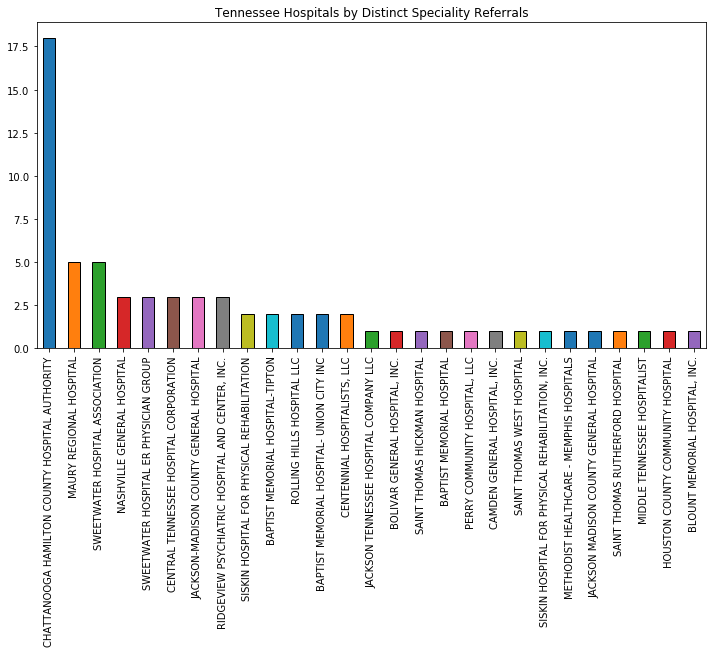

In [143]:
tn.to_Facility.value_counts().plot.bar(edgecolor='black',figsize=(12,6),
                                       title='Tennessee Hospitals by Distinct Speciality Referrals')
for p in ax.patches:
    b = p.get_bbox()
    val = format((b.y1 + b.y0))        
    ax.annotate(val, ((b.x0 + b.x1)/2 , b.y1 ))

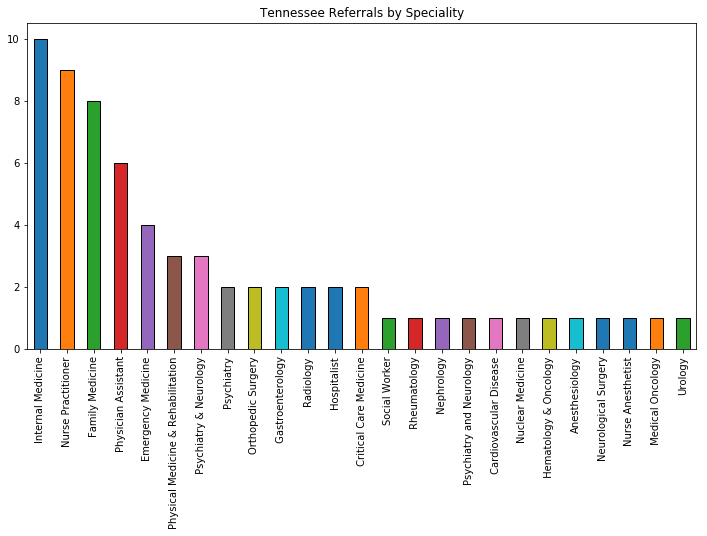

In [144]:
tn.from_speciality.value_counts().plot.bar(edgecolor='black',figsize=(12,6),
                                       title='Tennessee Referrals by Speciality')
for p in ax.patches:
    b = p.get_bbox()
    val = format((b.y1 + b.y0))        
    ax.annotate(val, ((b.x0 + b.x1)/2 , b.y1 ))

In [134]:
tn.patient_count.describe()

count       67.000000
mean      1838.716418
std       3454.236283
min         19.000000
25%        253.500000
50%        803.000000
75%       1514.000000
max      19718.000000
Name: patient_count, dtype: float64

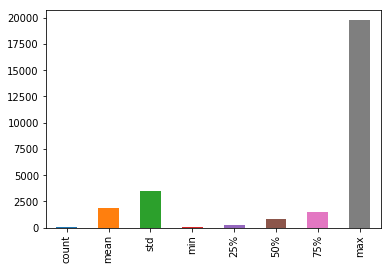

In [132]:
tn.patient_count.describe().plot.bar()

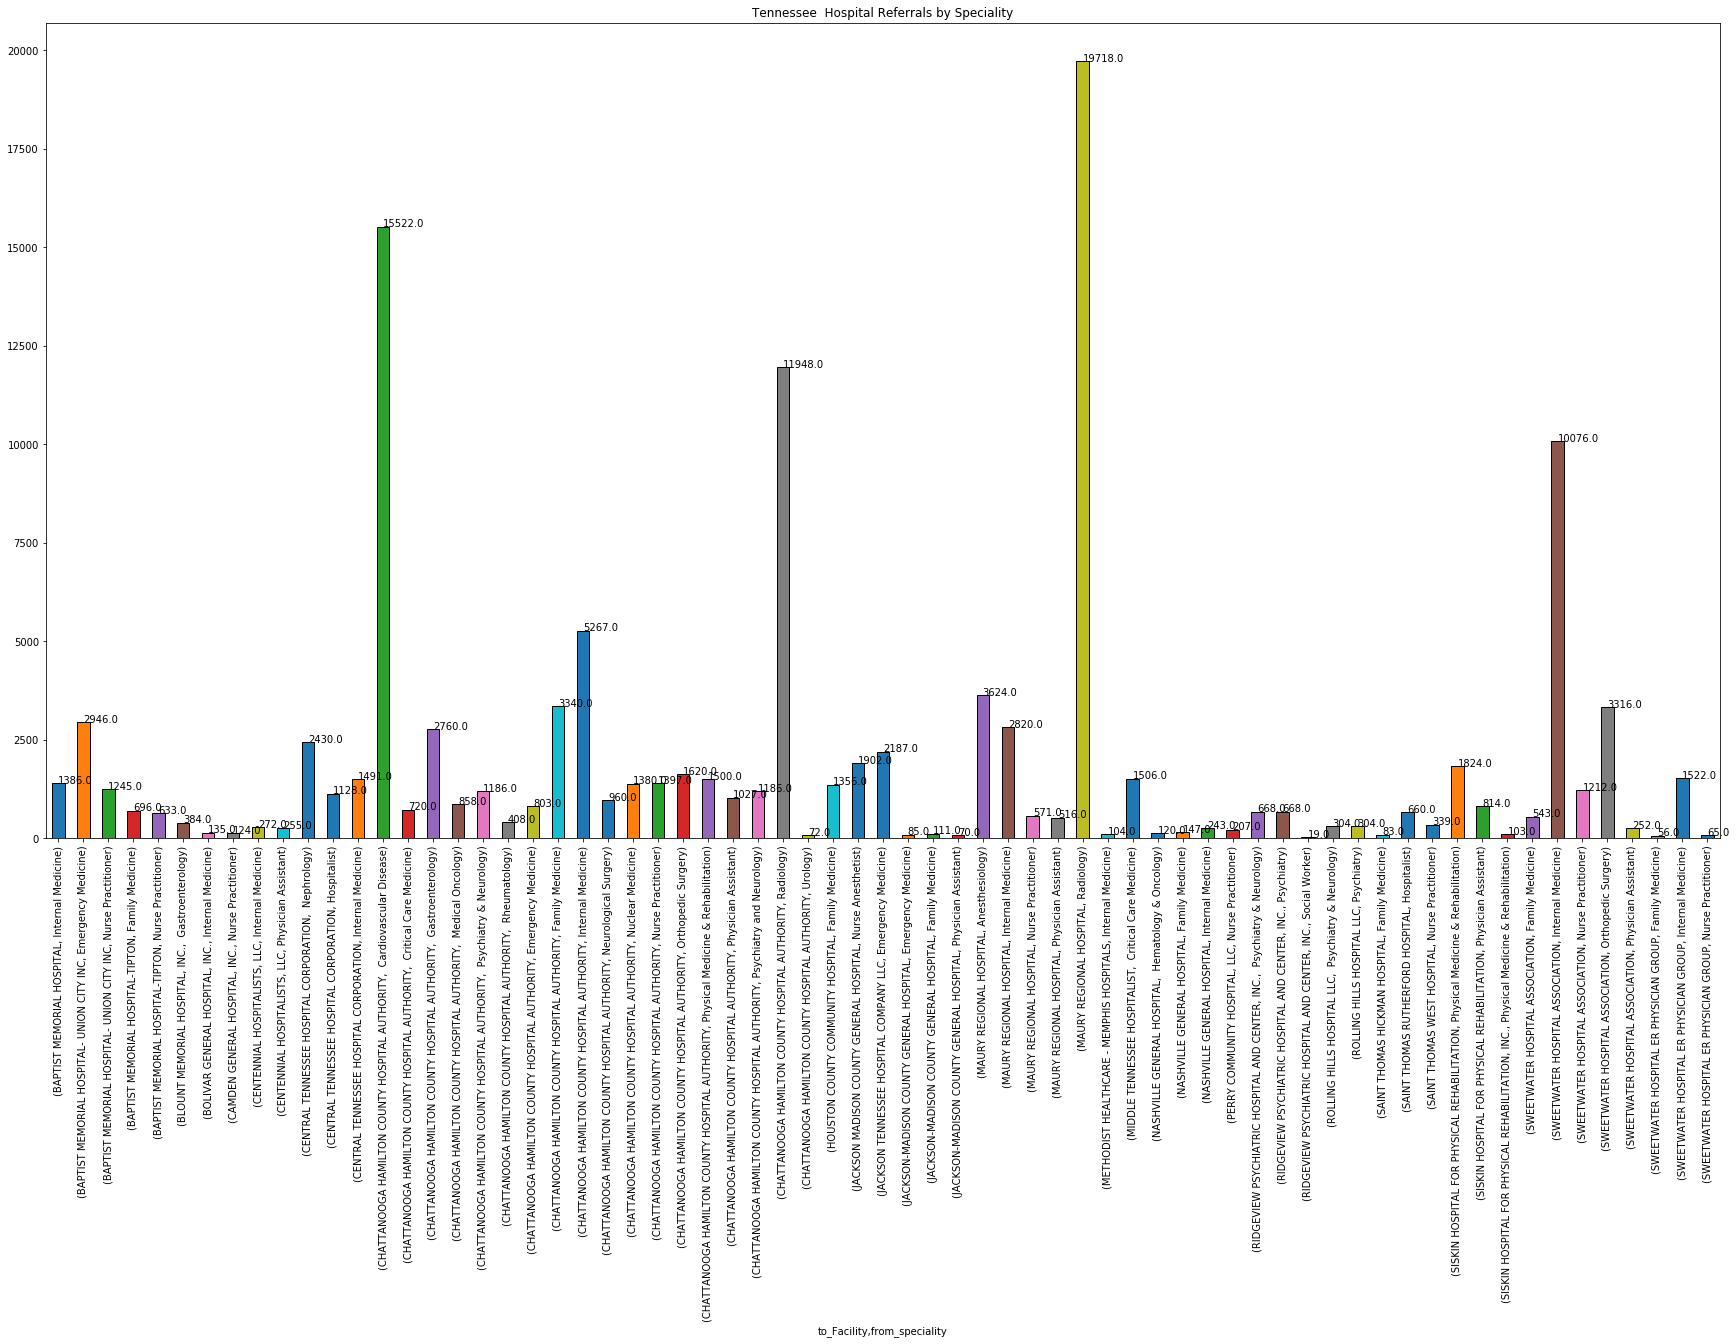

In [186]:
ax=tn.groupby(['to_Facility','from_speciality']).patient_count.sum().plot.bar(edgecolor='black',figsize=(30,15),
                                                                             # color=tn['from_speciality'],
                                                    title='Tennessee  Hospital Referrals by Speciality', stacked=True)
for p in ax.patches:
    b = p.get_bbox()
    val = format((b.y1 + b.y0))        
    ax.annotate(val, ((b.x0 + b.x1)/2 , b.y1 ));

In [171]:
tn_grouped=tn.groupby(['to_Facility','from_speciality']).patient_count.sum().sort_values(ascending=False).reset_index()

In [174]:
tn_grouped.head(1)

,to_Facility,from_speciality,patient_count
0,MAURY REGIONAL HOSPITAL,Radiology,19718


In [184]:
#ax=tn_grouped.plot.bar(edgecolor='black',figsize=(30,6),
#ax = sns.barplot(x="to_Facility", y="patient_count", data=tn_grouped)     
for p in ax.patches:
    b = p.get_bbox()
    val = format((b.y1 + b.y0))        
    ax.annotate(val, ((b.x0 + b.x1)/2 , b.y1 ));

In [98]:
nodes = pd.DataFrame(nodedata)
edges = pd.DataFrame(edgedata)
nodePath = 'nodes.csv'
edgePath = 'edges.csv'

In [499]:
serverURL = 'localhost:7474'
dbURL = 'http://localhost:7687/db/data'
account = "neo4j"
password = "****"

In [ ]:
nodes.to_csv(nodePath, index=False)
edges.to_csv(edgePath, index=False)

In [18]:
graph = Graph(dbURL)

In [ ]:
def path2url(path):
    return ('file:', u(path))


In [ ]:
#cypher params
nodename = "Provider"
edgename = "patient_count"
source_name = "from_npi"
dest_name = "to_npi"

In [ ]:
graph.cypher.execute("LOAD CSV WITH HEADERS FROM '%s' AS csvLine " % (path2url(nodePath)) +
                     " CREATE (p:"+nodename+" { id: toInt(csvLine.subid), name: csvLine.name, age: toInt(csvLine.age), 
                     fdg: toFloat(csvLine.fdg) })")


In [ ]:
#import edges
tx = graph.cypher.begin()
statement = "USING PERIODIC COMMIT 500" \
            + " LOAD CSV WITH HEADERS FROM '" + path2url(edgePath) + "' AS csvLine" \
            + " MATCH (person:"+source_name+" { id: toInt(csvLine.source)}),(person1:"+dest_name+" { id: toInt(csvLine.dest)})" \
            + " CREATE (person)-[:"+edgename+" { rating: toInt(csvLine.rating), weight: toInt(csvLine.weight) }]->(person1)"
tx.append(statement)
tx.commit()

In [ ]:

#NODE BY NODE IMPORT
for index, row in nodes.iterrows():
    node = Node(nodename, id=int(row['subid']), age = row['age'], fdg = row['fdg'], name = row['name'])
    graph.create(node)


In [ ]:
for index, row in hop.iterrows():
    source_node = graph.find_one(nodename, property_key='id', property_value=int(row['source']))
    dest_node = graph.find_one(nodename, property_key='id', property_value = int(row['dest']))
    relation = Relationship(source_node, edgename, dest_node, rating = int(row['rating']))
    graph.create(relation)

In [ ]:
CODE BACKUP
# Load CSV
LOAD CSV WITH HEADERS FROM 'file:///small_hopping.csv' AS line
CREATE (:Provider { npi: line.from_npi}) -[:Referred {patient_count: line.patient_count}]-> (:Provider {npi: line.to_npi})

#LOAD WITH PROPER EDGES/NODES
LOAD CSV WITH HEADERS FROM 'file:///small_hopping.csv' AS line
MERGE (f:Provider { npi: line.from_npi} )
MERGE (t:Provider { npi: line.to_npi} )
MERGE (f)-[:Referred {patient_count: line.patient_count}]->(t)

#Delete all nodes and edges
MATCH (p:Provider) DETACH DELETE p

In [ ]:
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS FROM 'file:///small_hop_ready4neo.csv' AS row 
MERGE (p1:Provider {npi:row.from_speciality}) 
MERGE (p2:Provider {npi:row.to_Facility}) 
MERGE (p1)-[:REFERRED_TO {patient_count:row.patient_count, transaction_count:row.transaction_count, 
average_day_wait:row.average_day_wait}]->(p2);
MATCH (p1:Provider)-[c:REFERRED_TO]->(p2:Provider) return p1,c,p2

In [500]:
from neo4j import GraphDatabase

class HelloWorldExample(object):

    def __init__(self, uri, user, password):
        self._driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self._driver.close()

    def print_greeting(self, message):
        with self._driver.session() as session:
            greeting = session.write_transaction(self._create_and_return_greeting, message)
            print(greeting)

    @staticmethod
    def _create_and_return_greeting(tx, message):
        result = tx.run("CREATE (a:Greeting) "
                        "SET a.message = $message "
                        "RETURN a.message + ', from node ' + id(a)", message=message)
        return result.single()[0]

In [ ]:




LOAD CSV WITH HEADERS FROM 'file:///small_hop_ready4neo.csv' AS row 
MERGE (p1:Provider {npi:row.from_speciality}) 
MERGE (p2:Provider {npi:row.to_Facility}) 
MERGE (p1)-[:REFERRED_TO {patient_count:row.patient_count, transaction_count:row.transaction_count, 
average_day_wait:row.average_day_wait}]->(p2);



MATCH (p1:Provider)-[c:REFERRED_TO]->(p2:Provider) return p1,c,p2

In [ ]:
:auto USING PERIODIC COMMIT 2000 LOAD CSV WITH HEADERS FROM 'file:///hop_ready4neo.csv' AS row 
CREATE (p1:Provider {npi:row.from_speciality}) 
CREATE (p2:Provider {npi:row.to_Facility}) 
CREATE (p1)-[:REFERRED_TO {patient_count:row.patient_count, transaction_count:row.transaction_count, 
average_day_wait:row.average_day_wait}]->(p2)

In [ ]:
which specialities refer to which hospitals, 
tennessee only ???